# Определение токсичности комментариев


**Задача:** построить модель, которая будет отсеивать токсичные комментарии на основании набора данных с разметкой о токсичности правок.</br>
</br>
**Условие:** метрика качества F1 не меньше 0.75.

**План работ:**
- подготовка данных
- векторизация с помощью CountVectorizer
- TF-IDF
- Word2vec
- Голосующий ансамбль
- Финальное тестирование модели

In [1]:
!pip install gensim

In [2]:
#сначала импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time

import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from gensim.models import Word2Vec

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import MaxAbsScaler

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trety\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trety\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trety\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Знакомство с данными и подготовка

In [4]:
#откроем файл с данными

try:
    data = pd.read_csv('datasets/toxic_comments.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
#выведем основную информацию
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


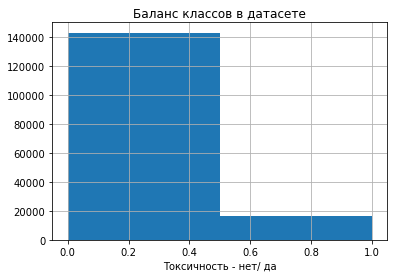

In [7]:
data['toxic'].hist(bins=2);
plt.title('Баланс классов в датасете')
plt.xlabel('Токсичность - нет/ да')
plt.show()

In [8]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

В нашем распоряжении 159.292 комментария с метками о токсичности. Выборка сильно несбалансирована - к токсичным комментариям относится только 10%, остальные 90% - к нетоксичным. Это необходимо будет учитывать при выборе и обучени моделей.

Чтобы снизить время обработки и обучения, выделим из датасета 50.000 комментариев для обучения и 12.500 комментариев для теста.

In [9]:
data_cut = data.sample(62500, random_state=7).reset_index(drop=True)
corpus_all = data_cut['text'].values
target_all = data_cut['toxic']

Приведем тексты к нижнему регистру:

In [10]:
corpus_all = [item.lower() for item in corpus_all]

Разделим данные на тренировочные и тестовые и в дальнейших шагах будем работать только с тренировочным корпусом текстов.

In [11]:
corpus, corpus_test, target, target_test = train_test_split(corpus_all, target_all, test_size=0.20, random_state=17)

In [12]:
print('Длина тренировочной выборки -', len(corpus), ', длина тестовой выборки -', len(corpus_test))

Длина тренировочной выборки - 50000 , длина тестовой выборки - 12500


Определим функцию, которая будет разбивать корпус текстов на батчи, объединять их через метку, затем токенизировать, лемматизировать и разбивать обратно на тексты

In [13]:
def step_lemmatizator(n_comments, corpus):
    corpus_lemm = []
    for batch_first_number in range (0, len(corpus), n_comments):
        #print(batch_first_number)
        corpus_batch = corpus[batch_first_number: batch_first_number+n_comments]
        #print(corpus_batch[0], corpus_batch[4999])
        corpus_batch_list = nltk.word_tokenize("/*/*/".join(corpus_batch))
        corpus_batch_lemm = " ".join(lemmatizer.lemmatize(element) for element in corpus_batch_list)
        corpus_batch_lemm_split = corpus_batch_lemm.split('/ * / * /')
        corpus_lemm += corpus_batch_lemm_split
    return corpus_lemm

In [14]:
n_comments = 5000

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
corpus_lemm = step_lemmatizator(n_comments, corpus)

Определим еще одну функцию - она будет выкидывать из текстов стоп-слова и символы, не несущие смысловой нагрузки

In [17]:
def cleaner(corpus):
    corpus_lemm_clear = []
    for text in corpus: 
        sub_text = re.sub(r'[^a-zA-Z]', ' ', text)
        split_text = sub_text.split()
        split_text_stopwords = [word for word in split_text if word not in stop_words]
        corpus_lemm_clear.append(" ".join(split_text_stopwords))
    return corpus_lemm_clear

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
corpus_lemm_clear = cleaner(corpus_lemm)

In [20]:
#проверим длину итогового корпуса
len(corpus_lemm_clear)

50000

Убедимся, что после всех преобразований тексты в исходном корпусе и в преобразованном совпадают.

In [21]:
corpus[306]

'"\n\n jingoism \n\nmy wanting what is in an article to be properly cited is more a reflection of your attitude than mine\nthats how your attitude looks from aside (no offence):\n the cited reference had a name by which it is easy to google it. so when the ref link to the telegraph was broken, you could have fixed it, like i did. instead you immediately got rid of the whole (inconvenient?) interesting fact. \n i\'ve put this fact into the ""tank"" article long ago, and since than check it once in half a year. and it is either deleted, or is distorted badly. you seem to have the article in your watch list, but do nothing to prevent it. \nlet\'s make a deal, you will be as careful and watchful to the fact as to any other, and i stop thinking of you as of a jingoist? ;) deal? 84.52.101.196  "'

In [22]:
corpus_lemm_clear[306]

'jingoism wanting article properly cited reflection attitude mine thats attitude look aside offence cited reference name easy google ref link telegraph wa broken could fixed like instead immediately got rid whole inconvenient interesting fact put fact tank article long ago since check half year either deleted distorted badly seem article watch list nothing prevent let make deal careful watchful fact stop thinking jingoist deal'

### Выводы

- При подготовке данных из датасета был выделен корпус из 50.000 текстов для обучения и 12.500 текстов для проверки моделей.
- Тексты были лемматизированы, очищены от цифр, символов и стоп-стов.

## Подготовка признаков

## Мешок слов

С помощью модуля CountVectorizer создадим мешок слов на основе лемматизированных текстов.
Для предсказаний будем использовать логистическую регрессию, дерево решений и градиентный бустинг.

In [23]:
#определим скорер для F1 метрики

scorer = make_scorer(f1_score, greater_is_better=True)

In [24]:
count_vector = CountVectorizer()
corpus_lemm_clear_bow = count_vector.fit_transform(corpus_lemm_clear)

#проверим количество признаков
corpus_lemm_clear_bow.shape

(50000, 81985)

In [25]:
#features_train, features_test, target_train, target_test = (
#    train_test_split(corpus_lemm_clear_bow, target, test_size=0.25, random_state=25))

**Логистическая регрессия**

In [26]:
model_cv_lr = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=25)

In [27]:
%%time
result =  cross_val_score(model_cv_lr, corpus_lemm_clear_bow, target, cv=3, scoring=scorer)
print(result.mean())

0.7385379192296687
Wall time: 12.5 s


In [28]:
#создадим датафрейм для фиксации результатов
score_table = pd.DataFrame([['CountVectorizer', 'LogisticRegression', result.mean()]], columns = ['preprocessing', 'model', 'f1_score'])
score_table

,preprocessing,model,f1_score
0,CountVectorizer,LogisticRegression,0.738538


**Градиентный бустинг**

In [29]:
model_cv_lgbm = LGBMClassifier(boosting_type='goss', n_estimators=500)

In [30]:
#преобразуем фичи и таргет, чтобы они работали с LGBM
features_train_cv = corpus_lemm_clear_bow.astype('float32')
target_train = target.astype('float32')

In [31]:
%%time
result =  cross_val_score(model_cv_lgbm, features_train_cv, target_train, cv=3, scoring=scorer)
print(result.mean())

0.7413844974321314
Wall time: 1min 59s


In [32]:
score_table = score_table.append({'preprocessing': 'CountVectorizer', 'model': 'LGBMClassifier', 'f1_score': result.mean()}, ignore_index=True)

**Дерево решений**

In [33]:
model_cv_tree = DecisionTreeClassifier(random_state=7)

In [34]:
%%time
result =  cross_val_score(model_cv_tree, corpus_lemm_clear_bow, target, cv=3, scoring=scorer)
print(result.mean())

0.6691087196396414
Wall time: 1min 5s


In [35]:
score_table = score_table.append({'preprocessing': 'CountVectorizer', 'model': 'DecisionTree', 'f1_score': result.mean()}, ignore_index=True)

**Случайная модель**

In [36]:
model_cv_dummy = DummyClassifier(strategy='stratified')

In [37]:
%%time
result =  cross_val_score(model_cv_dummy, corpus_lemm_clear_bow, target, cv=3, scoring=scorer)
print(result.mean())

0.10495816015407013
Wall time: 54.8 ms


In [38]:
score_table = score_table.append({'preprocessing': 'CountVectorizer', 'model': 'DummyClassifier', 'f1_score': result.mean()}, ignore_index=True)

## Мешок с биграммами

С помощью модуля CountVectorizer создадим не только мешок слов, но и биграммы на основе лемматизированных текстов.
Для предсказаний будем использовать логистическую регрессию и градиентный бустинг.

In [39]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [40]:
corpus_lemm_clear_ngram = bigram_vectorizer.fit_transform(corpus_lemm_clear)

In [41]:
corpus_lemm_clear_ngram.shape

(50000, 1065645)

In [42]:
#features_train, features_test, target_train, target_test = (
#    train_test_split(corpus_lemm_clear_ngram, target, test_size=0.25, random_state=25))

**Логистическая регрессия**

In [43]:
model_cvgram_lr = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=17)

In [44]:
%%time
result =  cross_val_score(model_cvgram_lr, corpus_lemm_clear_ngram, target, cv=3, scoring=scorer)
print(result.mean())

0.7535489379869783
Wall time: 1min 37s


In [45]:
score_table = score_table.append({'preprocessing': 'CountVectorizer+bigram', 'model': 'LogisticRegression', 'f1_score': result.mean()}, ignore_index=True)

**Градиентный бустинг**

In [46]:
model_cvgram_lgbm = LGBMClassifier(boosting_type='goss', n_estimators=500)

In [47]:
features_train_cvgram = corpus_lemm_clear_ngram.astype('float32')
target_train = target.astype('float32')

In [48]:
%%time
result =  cross_val_score(model_cvgram_lgbm, features_train_cvgram, target_train, cv=3, scoring=scorer)
print(result.mean())

0.7408764067512045
Wall time: 2min 49s


In [49]:
score_table = score_table.append({'preprocessing': 'CountVectorizer+bigram', 'model': 'LGBMClassifier', 'f1_score': result.mean()}, ignore_index=True)

**Случайная модель**

In [50]:
model_cvgram_dummy = DummyClassifier(strategy='stratified')

In [51]:
%%time
result =  cross_val_score(model_cvgram_dummy, corpus_lemm_clear_ngram, target, cv=3, scoring=scorer)
print(result.mean())

0.10143700966966061
Wall time: 171 ms


In [52]:
score_table = score_table.append({'preprocessing': 'CountVectorizer+bigram', 'model': 'DummyClassifier', 'f1_score': result.mean()}, ignore_index=True)

## TF IDF

Получим метрику TF IDF на основе лемматизированных текстов.
Для предсказаний будем использовать логистическую регрессию, линейный метод опорных векторов градиентный бустинг.

In [53]:
tf_idf_vectorizer = TfidfVectorizer()
corpus_lemm_clear_tfidf = tf_idf_vectorizer.fit_transform(corpus_lemm_clear)

In [54]:
corpus_lemm_clear_tfidf.shape

(50000, 81985)

In [55]:
#features_train, features_test, target_train, target_test = (
#    train_test_split(corpus_lemm_clear_tfidf, target, test_size=0.25, random_state=25))

**Логистическая регрессия**

In [56]:
model_tfivf_lr = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=25)

In [57]:
%%time
result =  cross_val_score(model_tfivf_lr, corpus_lemm_clear_tfidf, target, cv=5, scoring=scorer)
print(result.mean())

0.7358390051327806
Wall time: 5.85 s


In [58]:
score_table = score_table.append({'preprocessing': 'TF-IDF', 'model': 'LogisticRegression', 'f1_score': result.mean()}, ignore_index=True)

**Метод опорных векторов (линейный)**

In [59]:
model_tfidf_svc = LinearSVC(class_weight='balanced')

In [60]:
%%time
result =  cross_val_score(model_tfidf_svc, corpus_lemm_clear_tfidf, target, cv=3, scoring=scorer)
print(result.mean())

0.745719430674484
Wall time: 1.66 s


In [61]:
score_table = score_table.append({'preprocessing': 'TF-IDF', 'model': 'LinearSVC', 'f1_score': result.mean()}, ignore_index=True)

**Градиентный бустинг**

In [62]:
model_tfidf_lgbm = LGBMClassifier(boosting_type='goss', n_estimators=500)

In [63]:
features_train_tfidf = corpus_lemm_clear_tfidf.astype('float32')
target_train = target.astype('float32')

In [64]:
%%time
result =  cross_val_score(model_tfidf_lgbm, features_train_tfidf, target_train, cv=3, scoring=scorer)
print(result.mean())

0.7331476743280249
Wall time: 3min 22s


In [65]:
score_table = score_table.append({'preprocessing': 'TF-IDF', 'model': 'LGBMClassifier', 'f1_score': result.mean()}, ignore_index=True)

**Случайная модель**

In [66]:
model_tfidf_dummy = DummyClassifier(strategy='stratified')

In [67]:
%%time
result =  cross_val_score(model_tfidf_dummy, corpus_lemm_clear_tfidf, target, cv=3, scoring=scorer)
print(result.mean())

0.09722889943356287
Wall time: 78.1 ms


In [68]:
score_table = score_table.append({'preprocessing': 'TF-IDF', 'model': 'DummyClassifier', 'f1_score': result.mean()}, ignore_index=True)

## TF IDF с биграммами

In [69]:
tfidf_bigram_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

In [70]:
corpus_lemm_clear_tfidf_ngram = tfidf_bigram_vectorizer.fit_transform(corpus_lemm_clear)

In [71]:
corpus_lemm_clear_tfidf_ngram.shape

(50000, 1065645)

**Логстическая регрессия**

In [72]:
model_tfidfngram_lr = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=25)

In [73]:
%%time
result =  cross_val_score(model_tfidfngram_lr, corpus_lemm_clear_tfidf_ngram, target, cv=3, scoring=scorer)
print(result.mean())

0.7297603865185757
Wall time: 46.4 s


In [74]:
score_table = score_table.append({'preprocessing': 'TF-IDF bigrams', 'model': 'LogisticRegression', 'f1_score': result.mean()}, ignore_index=True)

**Linear SVC**

In [75]:
model_tfidfngram_svc = LinearSVC(class_weight='balanced')

In [76]:
result =  cross_val_score(model_tfidfngram_svc, corpus_lemm_clear_tfidf_ngram, target, cv=3, scoring=scorer)
print(result.mean())

0.7255428915783956


In [77]:
score_table = score_table.append({'preprocessing': 'TF-IDF bigrams', 'model': 'LinearSVC', 'f1_score': result.mean()}, ignore_index=True)

**Градиентный бустинг**

In [78]:
model_tfidfngram_lgbm = LGBMClassifier(boosting_type='goss', n_estimators=500)

In [79]:
features_train_tfidfngram = corpus_lemm_clear_tfidf_ngram.astype('float32')
target_train = target.astype('float32')

In [80]:
%%time
result =  cross_val_score(model_tfidfngram_lgbm, features_train_tfidfngram, target_train, cv=3, scoring=scorer)
print(result.mean())

0.7332662445394944
Wall time: 4min 59s


In [81]:
score_table = score_table.append({'preprocessing': 'TF-IDF bigrams', 'model': 'LGBMClassifier', 'f1_score': result.mean()}, ignore_index=True)

**Случайная модель**

In [82]:
model_tfidfngram_dummy = DummyClassifier(strategy='stratified')

In [83]:
%%time
result =  cross_val_score(model_tfidfngram_dummy, corpus_lemm_clear_tfidf_ngram, target, cv=3, scoring=scorer)
print(result.mean())

0.10138115188958659
Wall time: 123 ms


In [84]:
score_table = score_table.append({'preprocessing': 'TF-IDF bigrams', 'model': 'DummyClassifier', 'f1_score': result.mean()}, ignore_index=True)

## Word2vec

Воспульзуемся для создания векторных представлений слов алгоритм word2vec, который создает векторы слов с учетом их смысла.</br>
Проделаем следующие шаги:
- разобьем лемматизированный текст на токены
- определим модель Word2Vec и с ее помощью создадим словарь векторов. Зададим окно = 10, минимальную повторяемость слова в корпусе = 10 и размер вектора = 400
- получим вектор каждого текста, сложив все векторы слов в нём
- используем получившиеся векторные представления для обучения моделей

In [85]:
corpus_tokenize = [nltk.word_tokenize(element) for element in corpus_lemm_clear]

In [86]:
w2v_model = Word2Vec(corpus_tokenize, sg=1, vector_size=400, window=10, min_count=10)

Проверим наиболее близкие векторы к слову 'fuck':

In [87]:
w2v_model.wv.most_similar(positive=['fuck'])

[('yourselfgo', 0.7867441773414612),
 ('eppstein', 0.6798726320266724),
 ('bitches', 0.6778250932693481),
 ('ina', 0.6651097536087036),
 ('bongwarrior', 0.6488391160964966),
 ('motherfucking', 0.6315044164657593),
 ('tirade', 0.625715970993042),
 ('useless', 0.6150302290916443),
 ('fuckwit', 0.6121575832366943),
 ('scumbag', 0.611819326877594)]

Видим, что по запросу "наиболее близкие" алгоритм выдает слова, которые в определенном контексте также могут быть классифицированы как токсичные

In [88]:
def make_w2v_features(texts):
    w2v_features = []
    for element in texts:
        comment = np.zeros(400)
        element_tokenized = nltk.word_tokenize(element)
        for word in element_tokenized:
            if word in w2v_model.wv.key_to_index.keys():
                word_vector = w2v_model.wv[word]
                comment = comment + word_vector
        #print(comment) 
        #comment = pd.DataFrame(comment)
        w2v_features.append(comment)
        #print(len(w2v_features))
        
    return w2v_features

In [89]:
features_w2v = make_w2v_features(corpus_lemm_clear)

In [90]:
features_w2v = pd.DataFrame(features_w2v)

In [91]:
features_w2v.shape

(50000, 400)

При отправке полученных данных сырьем на обучение, модели начинают выдавать варнинги о несходимости алгоритма из-за большого разброса величин в сильно разреженной матрице. Стандартизируем данные, применив MaxAbsScaler, который позволяет работать с разреженными данными.

In [92]:
scaler = MaxAbsScaler()

In [93]:
scaler.fit(features_w2v)

MaxAbsScaler()

In [94]:
features_w2v_scaled = scaler.transform(features_w2v)

**Логистическая регрессия**

In [95]:
model_w2v_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=25)

In [96]:
%%time
result = cross_val_score(model_w2v_lr, features_w2v_scaled, target, cv=3, scoring=scorer)
print(result.mean())

0.5359697840904846
Wall time: 5.57 s


In [97]:
score_table = score_table.append({'preprocessing': 'word2vec', 'model': 'LogisticRegression', 'f1_score': result.mean()}, ignore_index=True)

**Linear SVC**

In [98]:
model_w2v_svc = LinearSVC(class_weight='balanced')

In [99]:
result =  cross_val_score(model_w2v_svc, features_w2v_scaled, target, cv=3, scoring=scorer)
print(result.mean())

0.6036974690822463


In [100]:
score_table = score_table.append({'preprocessing': 'word2vec', 'model': 'LinearSVC', 'f1_score': result.mean()}, ignore_index=True)

**Градиентный бустинг**

In [101]:
model_w2v_lgbm = LGBMClassifier(boosting_type='goss', n_estimators=500, class_weight='balanced')

In [102]:
features_train_w2v = features_w2v.astype('float32')
target_train = target.astype('float32')

In [103]:
result =  cross_val_score(model_w2v_lgbm, features_train_w2v, target_train, cv=3, scoring=scorer)
print(result.mean())

0.7243413898746788


In [104]:
score_table = score_table.append({'preprocessing': 'word2vec', 'model': 'LGBMClassifier', 'f1_score': result.mean()}, ignore_index=True)

**Случайная модель**

In [105]:
model_w2v_dummy = DummyClassifier(strategy='stratified')

In [106]:
result =  cross_val_score(model_w2v_dummy, features_w2v_scaled, target_train, cv=3, scoring=scorer)
print(result.mean())

0.10679805170992278


In [107]:
score_table = score_table.append({'preprocessing': 'word2vec', 'model': 'DummyClassifier', 'f1_score': result.mean()}, ignore_index=True)

**Итоговая таблица**

In [108]:
score_table.sort_values('f1_score', ascending=False)

,preprocessing,model,f1_score
4,CountVectorizer+bigram,LogisticRegression,0.753549
8,TF-IDF,LinearSVC,0.745719
1,CountVectorizer,LGBMClassifier,0.741384
5,CountVectorizer+bigram,LGBMClassifier,0.740876
0,CountVectorizer,LogisticRegression,0.738538
7,TF-IDF,LogisticRegression,0.735839
13,TF-IDF bigrams,LGBMClassifier,0.733266
9,TF-IDF,LGBMClassifier,0.733148
11,TF-IDF bigrams,LogisticRegression,0.729760
12,TF-IDF bigrams,LinearSVC,0.725543


## Создаем ансамбль на основе лучших моделей

Для того, чтобы улучшить метрику, создадим "голосующий" ансамбль на основе трёх лучших моделей. Создадим функцию, в которую будем передавать лучшие предсказания и "большинством голосов" выбирать ноль или единицу

In [109]:
def ensemble(pred_1, pred_2, pred_3):
    pred_result = np.zeros(len(pred_1))
    for i in range(len(pred_1)):
        pred_summ = pred_1[i] + pred_2[i] + pred_3[i]
        if pred_summ >= 2:
            pred_result[i] = 1
        else:
            pred_result[i] = 0
    return pred_result

Обучим три лучшие модели:

In [110]:
model_cvgram_lr.fit(corpus_lemm_clear_ngram, target)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=17)

In [111]:
model_tfidf_svc.fit(corpus_lemm_clear_tfidf, target)

LinearSVC(class_weight='balanced')

In [112]:
model_cv_lgbm.fit(features_train_cv, target)

LGBMClassifier(boosting_type='goss', n_estimators=500)

### Выводы:

- Для векторизации текста мы применили методы CountVectorizer, TF-IDF и Word2vec
- Для задачи классификации были использованы логистическая регрессия, градиентный бустинг, метод опорных векторов и дерево решений
- Все модели прошли проверку на адекватность в сравнении со случайной моделью
- По итогам скоринговой таблицы лучшими оказались логистическая регрессия в применении к мешку слов с биграммами, градиентный бустинг в применении к мешку слов и метод опорных векторов для TF-IDF.
- Три лучшие моделм были обучены на соответствующих данных
- Была определена функция для простроения голосующего ансамбля из трех лучших моделей

## Тестирование модели

Для того, чтобы протестировать полученную модель на тестовых данных, необходимо набор тестовых данных привести к лемматизированной форме, а потом обработать соответствующим образом для работы с каждой из моделей

**Лемматизация и очистка**

In [113]:
n_comments = 2500

In [114]:
corpus_test_lemm = step_lemmatizator(n_comments, corpus_test)

In [115]:
corpus_test_lemm_clear = cleaner(corpus_test_lemm)

Проверяем результат лемматизации и очистки

In [116]:
corpus_test_lemm_clear[345]

'hamboards removed speedy deletion tag placed article admit tendency wa decided see google news would anything doe considerably material work article deserves chance think company pass wp company'

In [117]:
corpus_test[345]

"hamboards \n\ni have removed the speedy deletion tag you placed on this article. i admit my tendency was to do the same, but i decided to see if google news would have anything, and it does. there's considerably material to work from there, and the article deserves a chance. i think the company passes wp:company."

Преобразуем полученный тестовый корпус следующим образом:
1. Применим CountVectorizer с биграммами и получим предсказание с помощью Логистической регрессии
2. Применим TF-IDF и получим предсказание с помощью метода опорных векторов
3. Применим CountVectorizer и снова получим предсказание с помощью Логистической регрессии

In [118]:
corpus_test_1 = bigram_vectorizer.transform(corpus_test_lemm_clear)

In [119]:
pred_1 = model_cvgram_lr.predict(corpus_test_1)

In [120]:
print('f1_score для первой модели', f1_score(target_test, pred_1))

f1_score для первой модели 0.7674703718839395


In [121]:
corpus_test_2 = tf_idf_vectorizer.transform(corpus_test_lemm_clear)

In [122]:
pred_2 = model_tfidf_svc.predict(corpus_test_2)

In [123]:
print('f1_score для второй модели', f1_score(target_test, pred_2))

f1_score для второй модели 0.735483870967742


In [124]:
corpus_test_3 = count_vector.transform(corpus_test_lemm_clear).astype('float32')

In [125]:
pred_3 = model_cv_lgbm.predict(corpus_test_3)

In [126]:
print('f1_score для третьей модели', f1_score(target_test, pred_3))

f1_score для третьей модели 0.7535979066724815


In [127]:
total_prediction = ensemble(pred_1, pred_2, pred_3)

In [128]:
f1_score(target_test, total_prediction)

0.7710743801652893

## Выводы

Была создана модель классификации комментариев по уровню токсичности, опробованы различные методы векторизации и различные модели машинного обучения с учителем. На основе трех наиболее успешных моделей был создан ансамбль, который позволил добиться метрики f1 на тестовых данных = 0.77